<a href="https://colab.research.google.com/github/Danieljoshua720/Electricity-demand-forecasting-AIML/blob/main/1_year_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
df=pd.read_csv('/content/powerdemand_5min_2021_to_2024_with weather.csv')

In [ ]:
df.head()

,Unnamed: 0,datetime,Power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,moving_avg_3
0,0,2021-01-01 00:30:00,2014.00,8.0,6.9,93.0,0.0,0.0,1017.0,2021.0,1.0,1.0,0.0,30.0,NaN
1,1,2021-01-01 00:35:00,2005.63,8.0,6.9,93.0,0.0,0.0,1017.0,2021.0,1.0,1.0,0.0,35.0,NaN
2,2,2021-01-01 00:40:00,1977.60,8.0,6.9,93.0,0.0,0.0,1017.0,2021.0,1.0,1.0,0.0,40.0,1999.076667
3,3,2021-01-01 00:45:00,1976.44,8.0,6.9,93.0,0.0,0.0,1017.0,2021.0,1.0,1.0,0.0,45.0,1986.556667
4,4,2021-01-01 00:50:00,1954.37,8.0,6.9,93.0,0.0,0.0,1017.0,2021.0,1.0,1.0,0.0,50.0,1969.470000


In [ ]:
df.tail()

,Unnamed: 0,datetime,Power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,moving_avg_3
337532,337532,2024-05-23 13:25:00,6784.81,38.0,19.9,35.0,100.0,14.8,1003.0,2024.0,5.0,23.0,13.0,25.0,6735.970000
337533,337533,2024-05-23 13:30:00,6786.59,40.0,20.2,32.0,90.0,18.4,1002.0,2024.0,5.0,23.0,13.0,30.0,6766.586667
337534,337534,2024-05-23 13:35:00,6877.74,40.0,20.2,32.0,90.0,18.4,1002.0,2024.0,5.0,23.0,13.0,35.0,6816.380000
337535,337535,2024-05-23 13:40:00,6931.80,40.0,20.2,32.0,90.0,18.4,1002.0,2024.0,5.0,23.0,13.0,40.0,6865.376667
337536,337536,2024-05-23 13:45:00,6991.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:


# Detect correct time column
if 'datetime' in df.columns:
    time_col = 'datetime'
elif 'time' in df.columns:
    time_col = 'time'
else:
    raise ValueError("No datetime column found")

df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
df = df.dropna(subset=[time_col])
df = df.sort_values(time_col).reset_index(drop=True)

target_col = 'Power demand'


In [ ]:
train_df = df[
    (df[time_col] >= '2023-01-01') &
    (df[time_col] <= '2023-12-31')
]

test_df = df[
    (df[time_col] >= '2024-01-01') &
    (df[time_col] <= '2024-12-31')
]

print("Train 2023 rows:", len(train_df))
print("Test 2024 rows :", len(test_df))


Train 2023 rows: 102075
Test 2024 rows : 38362


In [ ]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df[[target_col]])
test_scaled  = scaler.transform(test_df[[target_col]])


In [ ]:
def create_sequences(data, n_past):
    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(data[i-n_past:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_past = 24 * 7   # 1 week history (change if needed)

X_train, y_train = create_sequences(train_scaled, n_past)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


In [ ]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(n_past, 1)),
    Dropout(0.2),
    LSTM(64),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=64,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 0.0034
Epoch 2/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 2.9197e-04
Epoch 3/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 2.0481e-04
Epoch 4/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 1.9551e-04
Epoch 5/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - loss: 2.0817e-04
Epoch 6/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - loss: 1.4928e-04
Epoch 7/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - loss: 1.7401e-04
Epoch 8/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 1.8097e-04
Epoch 9/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 1.4326e-04
Epoch 10/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 1.6953e-04
Epoch 11/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 1.9515e-04
Epoch 12/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 1.3659e-04
Epoch 13/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 1.6992e-04
Epoch 14/20
1593/1593 ━━━

In [ ]:
model.save("lstm_power_model.h5")


In [ ]:
history = train_scaled.tolist()   # start with full 2023
predictions = []

for i in range(len(test_scaled)):
    x_input = np.array(history[-n_past:])
    x_input = x_input.reshape(1, n_past, 1)

    y_pred = model.predict(x_input, verbose=0)
    predictions.append(y_pred[0, 0])

    # append ACTUAL value (realistic forecasting)
    history.append([test_scaled[i, 0]])


In [ ]:
predictions = scaler.inverse_transform(
    np.array(predictions).reshape(-1, 1)
)

actual_2023 = train_df[target_col].values.reshape(-1, 1)


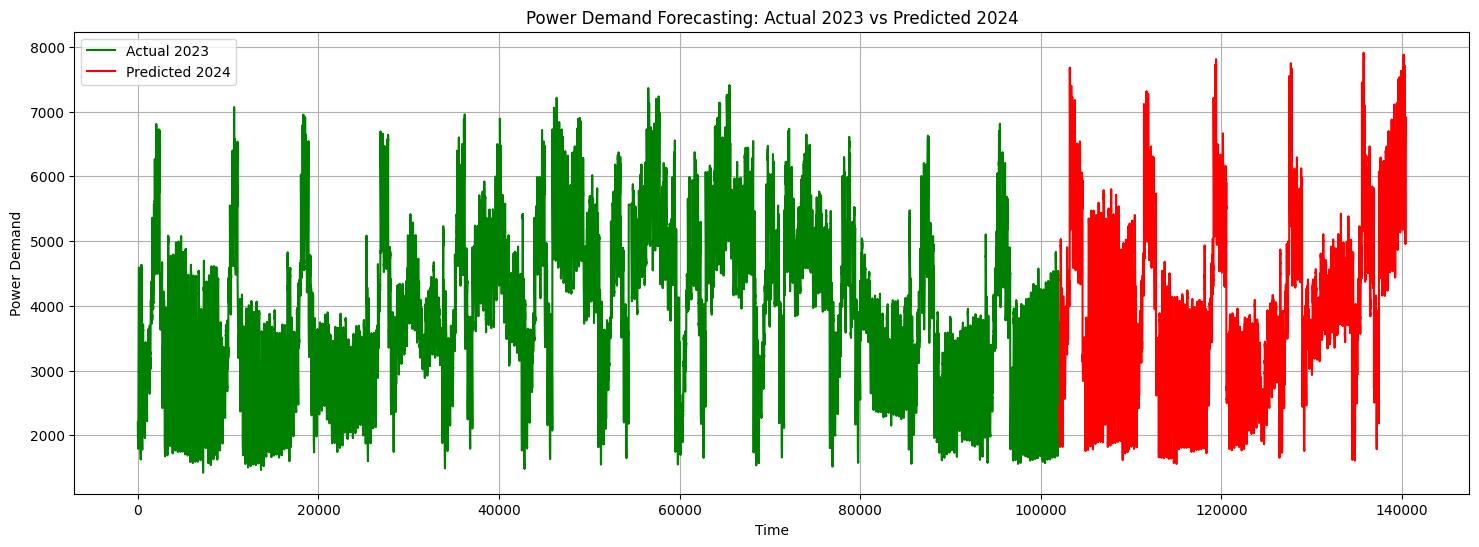

In [ ]:
plt.figure(figsize=(18, 6))

plt.plot(
    actual_2023,
    label='Actual 2023',
    color='green'
)

plt.plot(
    range(len(actual_2023), len(actual_2023) + len(predictions)),
    predictions,
    label='Predicted 2024',
    color='red'
)

plt.title('Power Demand Forecasting: Actual 2023 vs Predicted 2024')
plt.xlabel('Time')
plt.ylabel('Power Demand')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(len(actual_2023))
print(len(predictions))
print(len(test_df))


102075
38362
38362


In [ ]:
import pandas as pd
import numpy as np

df_plot = pd.DataFrame({
    "datetime": test_df[time_col].iloc[:len(predictions)].values,
    "Predicted_2024": predictions.flatten(),
    "Actual_2023": actual_2023[-len(predictions):].flatten()
})


In [ ]:
df_plot["datetime"] = pd.to_datetime(df_plot["datetime"])
df_plot["month"] = df_plot["datetime"].dt.month


In [ ]:
import matplotlib.pyplot as plt

def plot_monthwise(month_num, month_name):
    df_m = df_plot[df_plot["month"] == month_num]

    plt.figure(figsize=(18, 6))

    plt.plot(
        df_m["Actual_2023"].values,
        label="Actual 2023",
        color="green"
    )

    plt.plot(
        range(len(df_m["Actual_2023"]),
              len(df_m["Actual_2023"]) + len(df_m["Predicted_2024"])),
        df_m["Predicted_2024"].values,
        label="Predicted 2024",
        color="red"
    )

    plt.title(f"{month_name} 2024: Actual vs Predicted Power Demand")
    plt.xlabel("Time")
    plt.ylabel("Power Demand")
    plt.legend()
    plt.grid(True)
    plt.show()


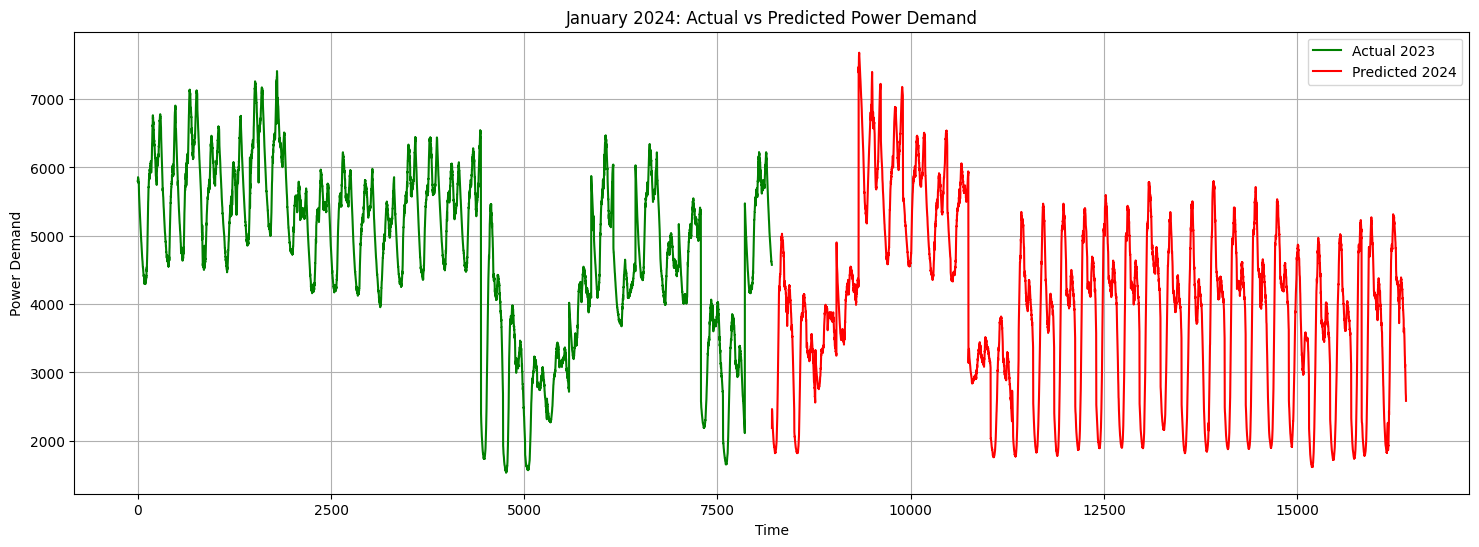

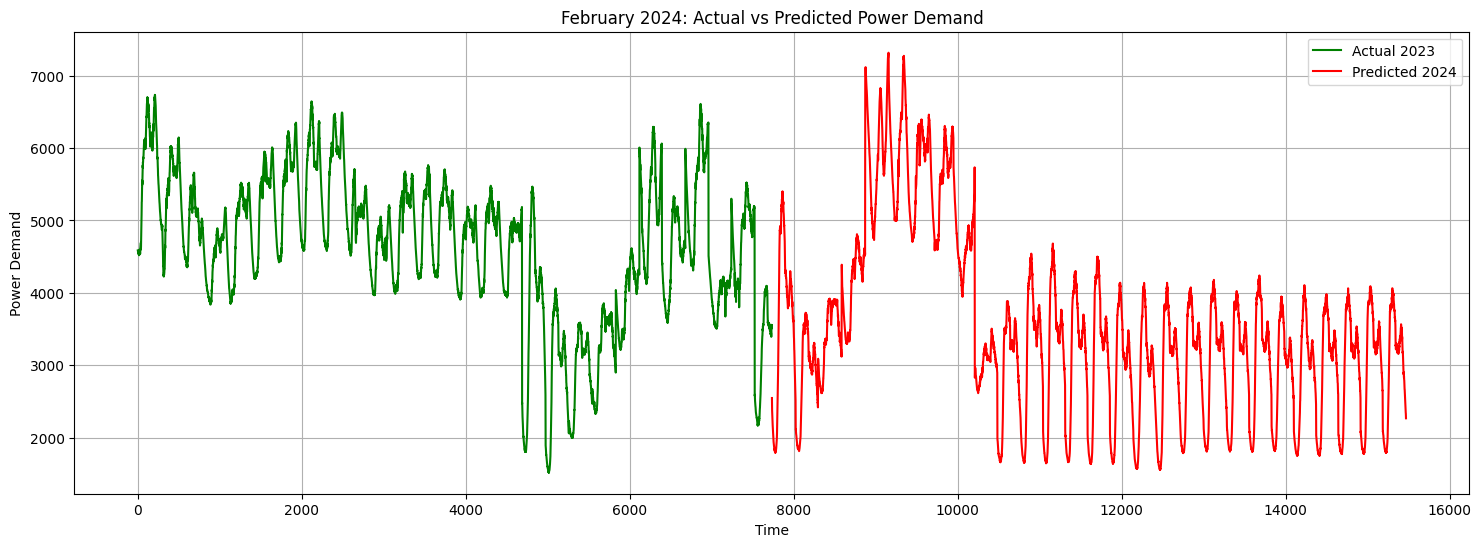

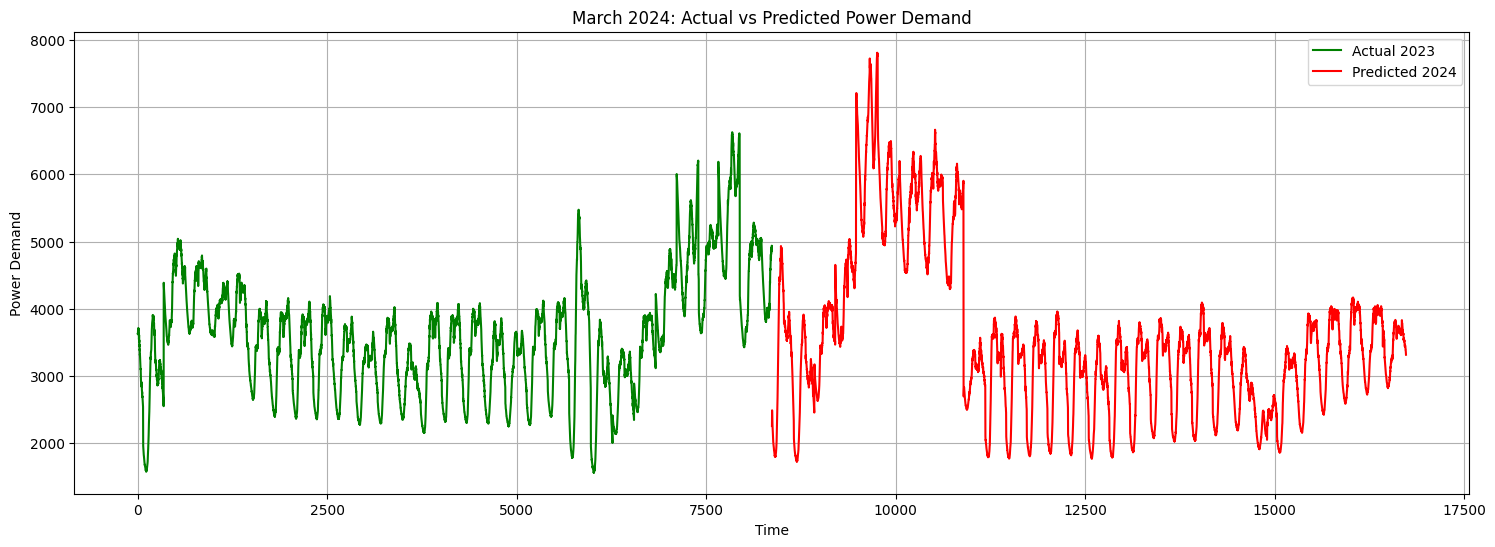

In [ ]:
plot_monthwise(1, "January")
plot_monthwise(2, "February")
plot_monthwise(3, "March")
